In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import Subset
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as utils
from IPython.display import HTML
import time
from torchvision import models
import torch.nn.functional as F
from scipy import linalg

In [2]:
dataset = datasets.CIFAR10(root="dataset/CIFAR10data", download=False,
                           transform=transforms.Compose([
                               transforms.Resize(64),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=32,
                                         shuffle=True, num_workers=2)

device = torch.device("cuda")

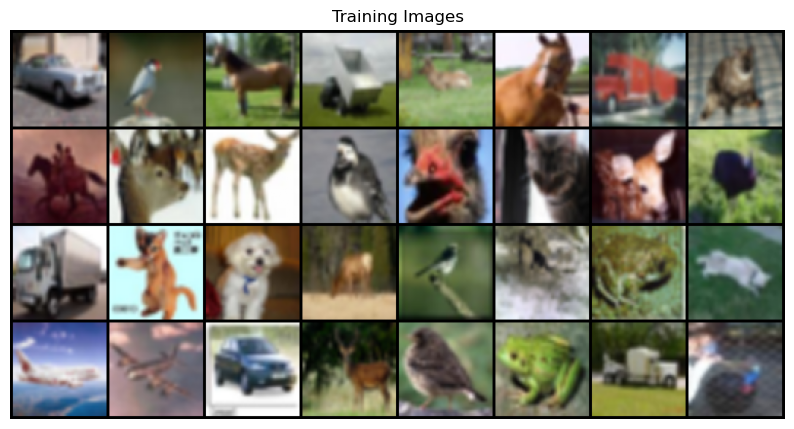

In [3]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(10,10))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(utils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [4]:
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            # input: N x channels_img x 64 x 64
            nn.Conv2d(
                channels_img, features_d, kernel_size=4, stride=2, padding=1
            ),
            nn.LeakyReLU(0.2),
            # _block(in_channels, out_channels, kernel_size, stride, padding)
            self.Dnet(features_d, features_d * 2, 4, 2, 1),
            self.Dnet(features_d * 2, features_d * 4, 4, 2, 1),
            self.Dnet(features_d * 4, features_d * 8, 4, 2, 1),
            nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=2, padding=0),
            nn.Sigmoid(),
        )

    def Dnet(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.disc(x)

In [5]:
class Generator(nn.Module):
    def __init__(self, channels_noise, channels_img, features_g):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            #Gnet(in_channels, out_channels, kernel_size, stride, padding)
            self.Gnet(channels_noise, features_g * 16, 4, 1, 0),
            self.Gnet(features_g * 16, features_g * 8, 4, 2, 1),
            self.Gnet(features_g * 8, features_g * 4, 4, 2, 1),
            self.Gnet(features_g * 4, features_g * 2, 4, 2, 1),
            nn.ConvTranspose2d(
                features_g * 2, channels_img, kernel_size=4, stride=2, padding=1
            ),
            nn.Tanh(),
        )

    def Gnet(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels,momentum=0.9),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.net(x)

In [6]:
def initialize_weights(model):
    # Initialize weights according to the DCGAN paper
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

In [7]:
#Intitating instances
gen = Generator(channels_noise = 100, channels_img = 3, features_g = 64).to(device)
disc = Discriminator(channels_img = 3, features_d = 64).to(device)
initialize_weights(gen)
initialize_weights(disc)
lr = 2e-4

In [8]:
optimGenerator = optim.Adam(gen.parameters(), lr=lr, betas=(0.5, 0.999))
optimDiscriminator = optim.Adam(disc.parameters(), lr=lr, betas=(0.5, 0.999))
criterion = nn.BCELoss()
fixed_noise = torch.randn(32, 100, 1, 1).to(device)
step = 0

In [9]:
class InceptionV3(nn.Module):
    """Pretrained InceptionV3 network returning feature maps"""

    # Index of default block of inception to return,
    # corresponds to output of final average pooling
    DEFAULT_BLOCK_INDEX = 3

    # Maps feature dimensionality to their output blocks indices
    BLOCK_INDEX_BY_DIM = {
        64: 0,
        192: 1,
        768: 2,
        2048: 3
    }

    def __init__(self,
                 output_blocks=[DEFAULT_BLOCK_INDEX],
                 resize_input=True,
                 normalize_input=True,
                 requires_grad=False):
        
        super(InceptionV3, self).__init__()

        self.resize_input = resize_input
        self.normalize_input = normalize_input
        self.output_blocks = sorted(output_blocks)
        self.last_needed_block = max(output_blocks)

        assert self.last_needed_block <= 3, \
            'Last possible output block index is 3'

        self.blocks = nn.ModuleList()

        
        inception = models.inception_v3(pretrained=True)

        # Block 0: input to maxpool1
        block0 = [
            inception.Conv2d_1a_3x3,
            inception.Conv2d_2a_3x3,
            inception.Conv2d_2b_3x3,
            nn.MaxPool2d(kernel_size=3, stride=2)
        ]
        self.blocks.append(nn.Sequential(*block0))

        # Block 1: maxpool1 to maxpool2
        if self.last_needed_block >= 1:
            block1 = [
                inception.Conv2d_3b_1x1,
                inception.Conv2d_4a_3x3,
                nn.MaxPool2d(kernel_size=3, stride=2)
            ]
            self.blocks.append(nn.Sequential(*block1))

        # Block 2: maxpool2 to aux classifier
        if self.last_needed_block >= 2:
            block2 = [
                inception.Mixed_5b,
                inception.Mixed_5c,
                inception.Mixed_5d,
                inception.Mixed_6a,
                inception.Mixed_6b,
                inception.Mixed_6c,
                inception.Mixed_6d,
                inception.Mixed_6e,
            ]
            self.blocks.append(nn.Sequential(*block2))

        # Block 3: aux classifier to final avgpool
        if self.last_needed_block >= 3:
            block3 = [
                inception.Mixed_7a,
                inception.Mixed_7b,
                inception.Mixed_7c,
                nn.AdaptiveAvgPool2d(output_size=(1, 1))
            ]
            self.blocks.append(nn.Sequential(*block3))

        for param in self.parameters():
            param.requires_grad = requires_grad

    def forward(self, inp):
        outp = []
        x = inp

        if self.resize_input:
            x = F.interpolate(x,
                              size=(299, 299),
                              mode='bilinear',
                              align_corners=False)

        if self.normalize_input:
            x = 2 * x - 1  # Scale from range (0, 1) to range (-1, 1)

        for idx, block in enumerate(self.blocks):
            x = block(x)
            if idx in self.output_blocks:
                outp.append(x)

            if idx == self.last_needed_block:
                break

        return outp
    
block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[2048]
model = InceptionV3([block_idx])
model=model.cuda()

/home/vponugo/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vponugo/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
def calculate_activation_statistics(images, model, batch_size=128, dims=2048, cuda=False):
    model.eval()
    act=np.empty((len(images), dims))
    
    if cuda:
        batch=images.cuda()
    else:
        batch=images
    pred = model(batch)[0]
    if pred.size(2) != 1 or pred.size(3) != 1:
        pred = adaptive_avg_pool2d(pred, output_size=(1, 1))

    act= pred.cpu().data.numpy().reshape(pred.size(0), -1)
    
    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)
    return mu, sigma

def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, \
        'Training and test mean vectors have different lengths'
    assert sigma1.shape == sigma2.shape, \
        'Training and test covariances have different dimensions'

    diff = mu1 - mu2

    
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = ('fid calculation produces singular product; '
               'adding %s to diagonal of cov estimates') % eps
        print(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError('Imaginary component {}'.format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return (diff.dot(diff) + np.trace(sigma1) +
            np.trace(sigma2) - 2 * tr_covmean)

def calculate_fretchet(images_real,images_fake,model):
    mu_1,std_1 = calculate_activation_statistics(images_real,model,cuda=True)
    mu_2,std_2 = calculate_activation_statistics(images_fake,model,cuda=True)
    fid_value = calculate_frechet_distance(mu_1, std_1, mu_2, std_2)
    return fid_value

In [11]:
gen.train()
disc.train()

Discriminator(
  (disc): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (4): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (5): Conv2d(512, 1, kernel_size=(4, 4), stride=(2, 2))
    (6): Sigmoid()
  )
)

In [12]:
#training block
GenLoss = []
DiscLoss = []
img_list = []
fretchet_distances = []
iters = 0

print("!!Training Started!!")
# start timing
time_start = time.time()
num_epochs = 50
for epoch in range(num_epochs):
    epoch = epoch+1

    for batch_idx, data in enumerate(dataloader,0):
        #training with real batch
        real = data[0].to(device)
        noise = torch.randn(128, 100, 1, 1).to(device)
        fake = gen(noise) #genrator img data

        ### Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
        disc_real = disc(real).reshape(-1)
        loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = disc(fake.detach()).reshape(-1)
        loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        loss_disc = (loss_disc_real + loss_disc_fake) / 2
        disc.zero_grad()
        loss_disc.backward()
        optimDiscriminator.step()

        ### Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
        output = disc(fake).reshape(-1)
        loss_gen = criterion(output, torch.ones_like(output))
        gen.zero_grad()
        loss_gen.backward()
        optimGenerator.step()

        # Print losses occasionally and print to tensorboard
        if batch_idx % 100 == 0:
            print(
                f"Epoch [{epoch}/{num_epochs}] Batch {batch_idx}/{len(dataloader)} \
                  Loss Discriminator: {loss_disc:.3f}, loss Generator: {loss_gen:.3f}"
            )
        #saving the losses for every 100 batch
        GenLoss.append(loss_gen.detach().cpu())
        DiscLoss.append(loss_disc.detach().cpu())
        
        
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs) and (batch_idx == len(dataloader)-1)):
            with torch.no_grad():
                fake = gen(fixed_noise).detach().cpu()
            img_list.append(utils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1
    fretchet_dist = calculate_fretchet(real, fake, model)
    print('Fretchet Distance: ', fretchet_dist)
    fretchet_distances.append(fretchet_dist)
        
time_end = time.time()
print('elapsed time：%.2f s.'%(time_end-time_start))

!!Training Started!!
Epoch [1/50] Batch 0/1563                   Loss Discriminator: 0.692, loss Generator: 0.705
Epoch [1/50] Batch 100/1563                   Loss Discriminator: 0.101, loss Generator: 2.986
Epoch [1/50] Batch 200/1563                   Loss Discriminator: 0.114, loss Generator: 2.945
Epoch [1/50] Batch 300/1563                   Loss Discriminator: 0.251, loss Generator: 1.735
Epoch [1/50] Batch 400/1563                   Loss Discriminator: 0.433, loss Generator: 1.539
Epoch [1/50] Batch 500/1563                   Loss Discriminator: 0.481, loss Generator: 1.451
Epoch [1/50] Batch 600/1563                   Loss Discriminator: 0.328, loss Generator: 1.840
Epoch [1/50] Batch 700/1563                   Loss Discriminator: 0.395, loss Generator: 2.494
Epoch [1/50] Batch 800/1563                   Loss Discriminator: 0.561, loss Generator: 1.448
Epoch [1/50] Batch 900/1563                   Loss Discriminator: 0.532, loss Generator: 1.212
Epoch [1/50] Batch 1000/1563   

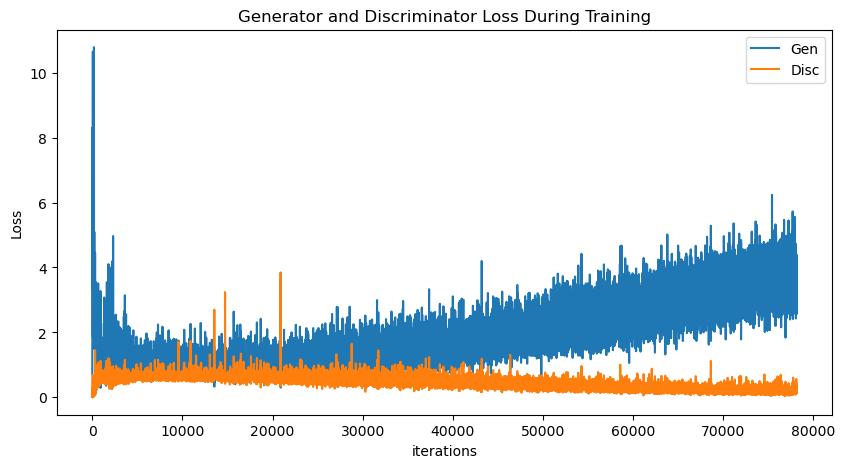

In [13]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(GenLoss,label="Gen")
plt.plot(DiscLoss,label="Disc")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

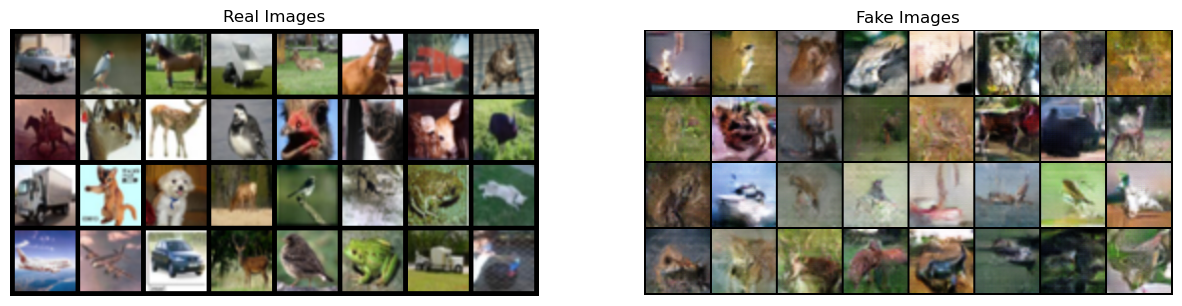

In [14]:
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(utils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.savefig('compare.png')
plt.show()

In [17]:
import pickle
with open('fd_dcgan.pickle', 'wb') as f:
    pickle.dump(fretchet_distances, f)

In [22]:
import pickle
file = open('fd_dcgan.pickle', 'rb')
wgan = pickle.load(file)
dcgan = fretchet_distances

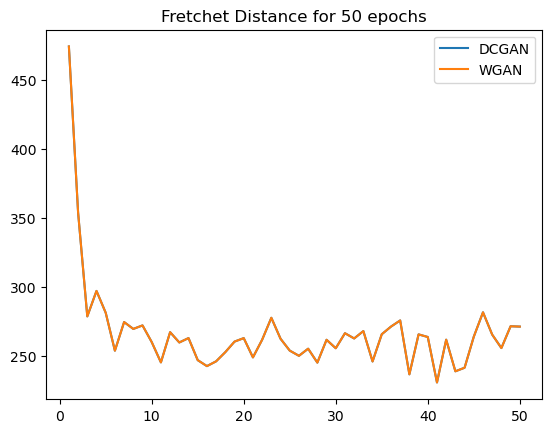

In [23]:
plt.plot(np.arange(1,51), dcgan, label = 'DCGAN')
plt.plot(np.arange(1,51), wgan, label = 'WGAN')
plt.title('Fretchet Distance for 50 epochs')
plt.legend()
plt.show()